In [1]:
import numpy as np
import random as random
import pandas as pd
import matplotlib.pyplot as plt

from sudoku import Sudoku
from sudoku import Solver

# numbers dataset
from keras.datasets import mnist

from tensorflow.keras import backend as K
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# import of .png
import matplotlib.image as mpimg

import cv2


Using TensorFlow backend.


In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [7]:
# replace zeros by empty cell
x_train[y_train[:] == 0] = np.zeros([28,28])
x_test[y_test[:] == 0] = np.zeros([28,28])
# normalizing data
x_train = x_train/255
x_test = x_test/255

In [7]:
# generate data for training

# sudoku = Sudoku()

# num_datapoints = 500
# # data = {"X" : [], "y": []}
# for k in range(139,num_datapoints):
#     sudoku.download_new()
#     canvas_size = 400
#     scale = 29
#     background_size = scale*9+1
#     center = int(canvas_size/2)*np.ones(2, dtype = "int")-int(background_size/2)*np.ones(2, dtype = "int")
#     board_position = (random.randint(-40,40), random.randint(-40,40)) # relative to the center
#     canvas_noise_params = (random.random(),random.random())
#     square_noise_params = (random.random()*0.3, random.random()*0.5)
#     pts = 1

#     canvas = np.random.normal(canvas_noise_params[0], canvas_noise_params[1], [canvas_size,canvas_size])
#     canvas[canvas < 0] = 0
#     canvas[canvas > 1] = 1
#     background = np.zeros([background_size, background_size])
#     grid = np.zeros(background.shape)
#     squares = np.zeros(background.shape)
#     square_len = int((background_size+8)/9)

#     for i in range(9):
#         for j in range(9):
#             grid[square_len*(i)-1*i:square_len*(i+1)-1*i,square_len*(j)-1*j:square_len*(j+1)-1*j] = np.pad(np.zeros([square_len-2*pts,square_len-2*pts]),pts, mode="constant", constant_values=1)
#             number = sudoku.current_state[i,j]
#             square_content = x_train[y_train[:] == number][random.randint(0,len(x_train[y_train[:] == number])-1)]
#             noise = np.random.normal(square_noise_params[0], square_noise_params[1], square_content[square_content == 0].shape[0])
#             noise[noise < 0] = 0
#             noise[noise > 1] = 1
#             square_content[square_content == 0] = square_content[square_content == 0] + noise
#             squares[square_len*(i)-1*i:square_len*(i+1)-1*i, square_len*(j)-1*j:square_len*(j+1)-1*j] = np.pad(square_content, pts, mode="constant", constant_values=0)
#     board = background + grid + squares

#     centered_position = center + board_position
#     canvas[centered_position[0]:centered_position[0] + board.shape[0], centered_position[1]:centered_position[1] + board.shape[1]] = board
# #     plt.figure(figsize=(10,10))
# #     plt.imshow(canvas, cmap = "Greys")
# #     data["X"].append(canvas)
# #     data["y"].append(sudoku.current_state)
#     print("generated datapoint " + str(k+1) + "/" + str(num_datapoints))
#     np.savetxt("data/X_"+str(k)+".txt", canvas,fmt='%1.2f')
#     np.savetxt("data/y_"+str(k)+".txt", sudoku.current_state,fmt='%1.0f')
# #     plt.show()

In [520]:
def fill_squares(grid, square_size, grid_thickness, square_grid_thickness, mode, data, noise):
    for i in np.arange(9):
        pos_i = i*square_size + ((i-1)-int(i/3))*grid_thickness  + int(i/3)*square_grid_thickness+1
        for j in np.arange(9):
            pos_j = j*square_size + ((j-1)-int(j/3))*grid_thickness  + int(j/3)*square_grid_thickness+1
            
            if mode == "noise":
                grid[pos_i:pos_i+square_size,pos_j:pos_j+square_size] = np.random.normal(noise[0],noise[1],[square_size,square_size])

            elif mode == "numbers":
                rand_num = data[np.random.randint(data.shape[0])]
                rand_num = cv2.resize(rand_num, (square_size,square_size), interpolation = cv2.INTER_AREA)
                
                if np.random.rand() > 0.5:
                    grid[pos_i:pos_i+square_size,pos_j:pos_j+square_size] = rand_num
                else:
                    grid[pos_i:pos_i+square_size,pos_j:pos_j+square_size] = np.zeros([square_size,square_size])
            
            else:
                grid[pos_i:pos_i+square_size,pos_j:pos_j+square_size] = np.zeros([square_size,square_size])
    
    return grid

def create_sudoku_grid(square_size, grid_thickness, square_grid_thickness, grid_border_thickness, grid_alpha, border_alpha, noise,
                       filling_data, square_noise=(0,0), filling_mode="none"
                      ):
    
    grid_size = 6*grid_thickness + 9*square_size + 2*square_grid_thickness
    background_size = grid_size+2*grid_border_thickness

    background = np.zeros([grid_size, grid_size])
    vline = grid_alpha*np.ones([grid_size, grid_thickness])
    hline = vline.T
    vline_ = grid_alpha*np.ones([grid_size, square_grid_thickness])
    hline_ = vline_.T
    
    for i in np.arange(8):
        pos = (i+1)*square_size + (i-int(i/3))*grid_thickness  + int(i/3)*square_grid_thickness
        if i in [0,1,3,4,6,7]:
            background[pos:pos+grid_thickness,:] = hline
            background[:,pos:pos+grid_thickness] = vline
            
        else:
            background[pos:pos+square_grid_thickness,:] = hline_
            background[:,pos:pos+square_grid_thickness] = vline_
            
    background = fill_squares(background, square_size, grid_thickness, square_grid_thickness, filling_mode, filling_data, square_noise)

    background = np.pad(background, pad_width=grid_border_thickness, constant_values=border_alpha)
    
    background_noise = np.random.normal(noise[0], noise[1], [background_size,background_size])
    background = background+background_noise
    background = (background-np.min(background))/(np.max(background)-np.min(background))
    
    return background

def create_training_image(sudoku_grid, canvas_size, output_dim=(128,128), offcenter=(0,0), canvas_noise=(0.0,0.0)):
    offcenter = np.array(offcenter)
    canvas = np.zeros([canvas_size, canvas_size])
    canvas_noise = np.random.normal(canvas_noise[0], canvas_noise[1], [canvas_size,canvas_size])
    canvas = canvas+canvas_noise
    if canvas_noise.any() != 0:
        canvas = (canvas-np.min(canvas))/(np.max(canvas)-np.min(canvas))
    
    sudoku_size=sudoku_grid.shape[0]
    center = int(canvas_size/2)-int(sudoku_size/2)
    offcenter[abs(offcenter) > int((canvas_size - sudoku_grid.shape[0])/2)] = int((canvas_size - sudoku_grid.shape[0])/2-1) 
    
    canvas[center+offcenter[0]:center+offcenter[0]+sudoku_size,center+offcenter[1]:center+offcenter[1]+sudoku_size] = sudoku_grid

    # resize image
    canvas_resized = cv2.resize(canvas, output_dim, interpolation = cv2.INTER_AREA)
    return canvas_resized

def find_sudoku_corners(square_size, grid_thickness, square_grid_thickness, grid_border_thickness,
                        canvas_size_in, canvas_size_out, offcenter
                       ):
    
    grid_size = 6*grid_thickness + 9*square_size + 2*square_grid_thickness
    overlay = np.zeros(sudoku_img.shape)
    scale=canvas_size_out/canvas_size_in
    x0, y0 = (canvas_size_in/2+offcenter[0], canvas_size_in/2+offcenter[1])
    x0, y0 = x0*scale, y0*scale
    corner = (square_grid_thickness+2*grid_thickness+4.5*square_size+grid_border_thickness)
    if grid_size%2 != 0:
        corner = corner*scale
        a = np.array([round(x0-corner), round(y0-corner)])
        b = np.array([round(x0-corner), round(y0+corner)])
        c = np.array([round(x0+corner), round(y0-corner)])
        d = np.array([round(x0+corner), round(y0+corner)])
        
    else:
        corner = corner*scale
        a = np.array([round(x0-corner-1*scale), round(y0-corner-1*scale)])
        b = np.array([round(x0-corner-1*scale), round(y0+corner)])
        c = np.array([round(x0+corner), round(y0-corner-1*scale)])
        d = np.array([round(x0+corner), round(y0+corner)])
        
    return a,b,c,d

    

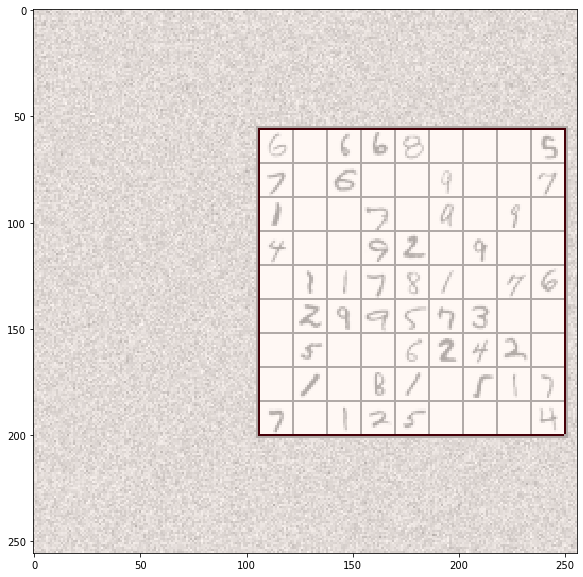

In [530]:
square_size = 15
grid_thickness = 1
square_grid_thickness = 1
grid_border_thickness = 2
grid_alpha = 1
border_alpha = 1
noise = (0.0,0.0)
canvas_size_in = 256
canvas_size_out = 256
offcenter = (0,50)
canvas_noise = (0,0.1)

sudoku_grid = create_sudoku_grid(square_size, grid_thickness, square_grid_thickness, grid_border_thickness, grid_alpha, border_alpha, noise,
                                x_train, filling_mode="numbers")
sudoku_img = create_training_image(sudoku_grid, canvas_size_in, (canvas_size_out,canvas_size_out), offcenter, canvas_noise)

a, b, c, d = find_sudoku_corners(square_size, grid_thickness, square_grid_thickness, grid_border_thickness, canvas_size_in, canvas_size_out, offcenter)

img_1D = np.reshape(sudoku_img, [1,sudoku_img.shape[0]*sudoku_img.shape[1]])
corners = np.array([a, b, c, d]).reshape([1,2*4])
data = np.append(img_1D,corners)

f = open("data.txt", "a")
f.write(" ".join(np.array(data, dtype=str)))
f.close()


plt.figure(figsize=(10,10))
plt.imshow(sudoku_img, cmap="Greys")

overlay = np.zeros(sudoku_img.shape)
overlay[a[0],a[1]:b[1]] = 1
overlay[b[0]:c[0],b[1]] = 1
overlay[c[0],c[1]:d[1]] = 1
overlay[a[0]:d[0],a[1]] = 1

plt.imshow(overlay, cmap="Reds", alpha=0.7)
plt.show()